# Object-based colocalization

In [1]:
# /// script
# requires-python = ">=3.12"
# dependencies = [
#     "matplotlib",
#     "ndv[jupyter,vispy]",
#     "numpy",
#     "scikit-image",
#     "scipy",
#     "shapely",
#     "tifffile",
# ]
# ///

# Description
In this Notebook...

## Objectives
- ...
- ...

## Table of Contents
- ...
- ...

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix


from shapely.geometry import Point, box

Describe what is the next step/content of the cell (if necessary)...

Can add images, screenshots of slided, ...

In [3]:
points = np.load(
    "/Users/mariatheiss/Documents/Teaching/Bobiac_teaching_material/object_based_coloc/data/p_100.npy"
)
points_g = np.load(
    "/Users/mariatheiss/Documents/Teaching/Bobiac_teaching_material/object_based_coloc/data/g_p_100.npy"
)
points_r = np.load(
    "/Users/mariatheiss/Documents/Teaching/Bobiac_teaching_material/object_based_coloc/data/p_d0-75_100.npy"
)

In [4]:
def plotloc(points):
    plt.scatter(points[:, 0], points[:, 1], c="k")
    plt.xlabel("x")
    plt.ylabel("y")

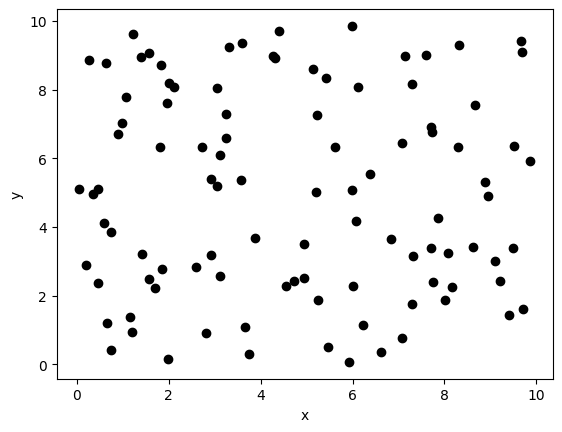

In [5]:
plotloc(points)

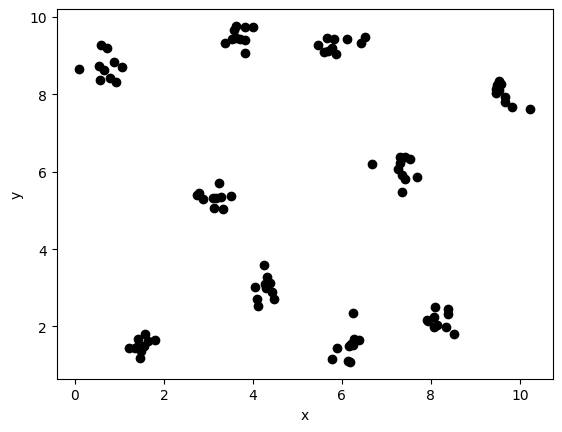

In [6]:
plotloc(points_g)

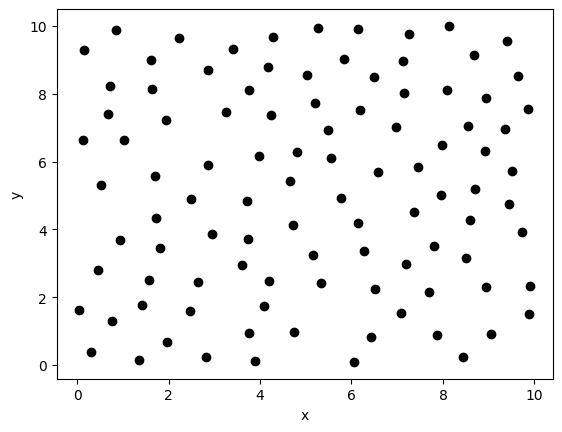

In [7]:
plotloc(points_r)

# Mean nearest neighbour distance

In [8]:
def meanNN(points):
    dists = distance_matrix(points, points)
    np.fill_diagonal(
        dists, np.inf
    )  # the nearest neighbour of a point is always itself. Mask diagonal with infinity
    mindists = np.min(dists, axis=0)

    return mindists

In [9]:
nndist_points = meanNN(points)
nndist_gauss = meanNN(points_g)
nndist_dist = meanNN(points_r)

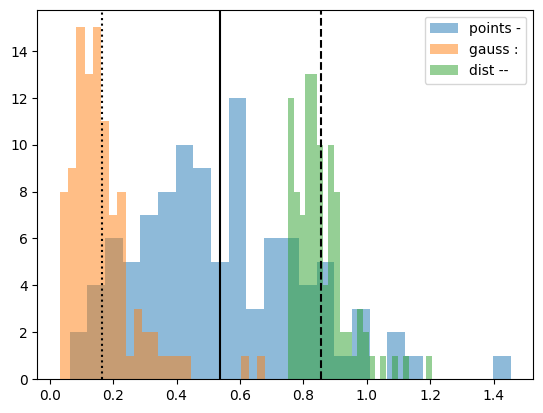

In [65]:
plt.hist(nndist_points, label="points -", alpha=0.5, bins=25)
plt.hist(nndist_gauss, label="gauss :", alpha=0.5, bins=25)
plt.hist(nndist_dist, label="dist --", alpha=0.5, bins=25)
plt.axvline(np.mean(nndist_points), c="k", linestyle="-")
plt.axvline(np.mean(nndist_gauss), c="k", linestyle=":")
plt.axvline(np.mean(nndist_dist), c="k", linestyle="--")
plt.legend()

# Nearest neighbour function

In [66]:
def nearest_neighbour_function(points, radii, alpha=0.05):
    """
    Computes the nearest neighbour function for a set of 2D points.

    Parameters:
    - points: array of shape (n_points, 2) representing the coordinates of the points
    - radii: array of radii at which to evaluate the nearest neighbour distance

    Returns:
    - nn_distances: nearest neighbour distances at each radius
    """

    max_x, max_y = np.max(points, axis=0)
    min_x, min_y = np.min(points, axis=0)
    (max_x - min_x) * (max_y - min_y)

    n1 = len(points)

    dists = distance_matrix(points, points)
    np.fill_diagonal(dists, np.inf)  # Set diagonal to infinity to ignore self-distances
    S = np.zeros_like(radii, dtype=float)
    di = np.min(dists, axis=1)  # nearest neighbour distances per point

    for i, r in enumerate(radii):
        within_r = di < r

        S[i] = len(di[within_r]) / n1

    return S

In [12]:
def getnulldist(points, radii):
    max_x, max_y = np.max(points, axis=0)
    min_x, min_y = np.min(points, axis=0)
    area = (max_x - min_x) * (max_y - min_y)

    n1 = len(points)

    mu0 = np.zeros_like(radii, dtype=float)

    for i, r in enumerate(radii):
        mu0[i] = 1 - np.exp(-(n1 / area) * np.pi * (r**2))

    return mu0

In [13]:
radii = np.arrange(0.1, 3, 0.01)  # radii for which to compute the K-function

In [14]:
S = nearest_neighbour_function(points, radii)
S_g = nearest_neighbour_function(points_g, radii)
S_r = nearest_neighbour_function(points_r, radii)

In [15]:
nulldist = getnulldist(points, radii)
nulldist_g = getnulldist(points_g, radii)
nulldist_r = getnulldist(points_r, radii)

In [16]:
def plot_nn_function(S, radii, nulldist=None):
    if nulldist is not None:
        plt.plot(radii, nulldist, c="red", alpha=0.5, label="null‐model mean")

    plt.plot(radii, S, c="black", alpha=0.8, label="observed")

    plt.legend()
    plt.xlabel("radius (r)")
    plt.ylabel("S(r)")
    plt.tight_layout()
    plt.show()

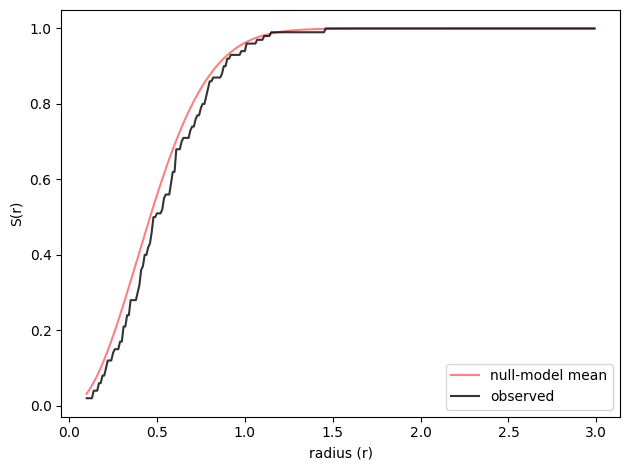

In [17]:
plot_nn_function(S, radii, nulldist)

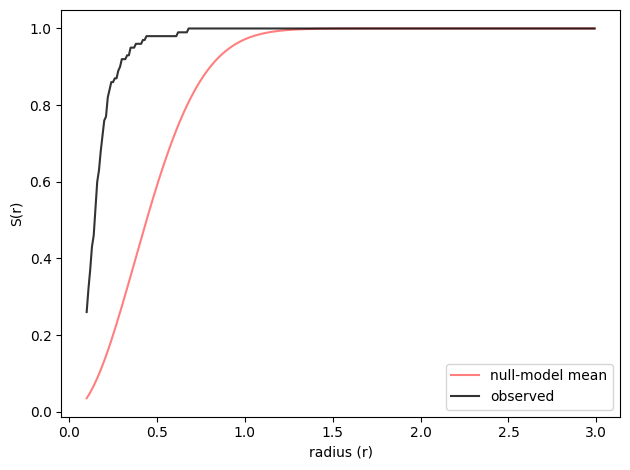

In [18]:
plot_nn_function(S_g, radii, nulldist_g)

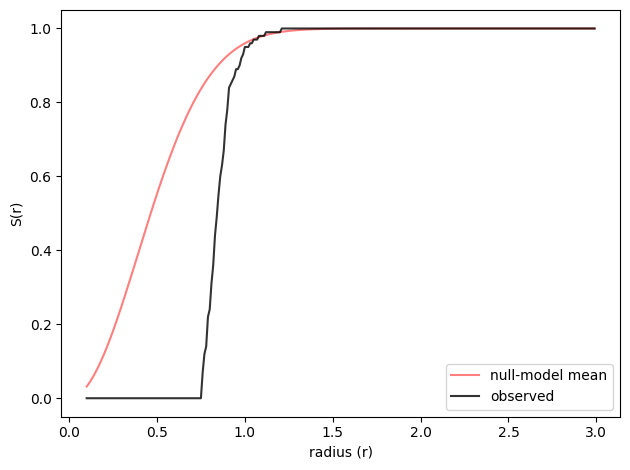

In [19]:
plot_nn_function(S_r, radii, nulldist_r)

# Ripleys' K function

In [22]:
def ripleys_k_function(points, radii, area=None, edge_correction=False):
    """
    Computes Ripley's K function for a set of 2D points.

    Parameters:
    - points: list of (x, y) tuples
    - radii: array-like of radii at which to evaluate K
    - area: total area of the observation window; if None, calculated from bounding box
    - edge_correction: if True, applies basic border edge correction (optional, not implemented in this version)

    Returns:
    - ks: K-function values at each radius
    """

    n_points = len(points)
    ks = np.zeros_like(radii, dtype=float)
    max_x, max_y = np.max(points, axis=0)

    if area is None:
        min_x, min_y = np.min(points, axis=0)
        area = (max_x - min_x) * (max_y - min_y)
    else:
        min_x = 0
        min_y = 0
        max_x = np.max([max_x, np.sqrt(area)])
        max_y = np.max([max_y, np.sqrt(area)])

    square = box(min_x, min_y, max_x, max_y)

    dists = distance_matrix(points, points)

    if edge_correction:
        area_correction = np.zeros_like(dists)
        for i in range(n_points):
            for j in range(n_points):
                if i == j:
                    continue
                circle = Point(points[i]).buffer(dists[i][j])
                area_correction[i][j] = circle.area / circle.intersection(square).area

    for i, r in enumerate(radii):
        within_r = (dists < r) & (dists > 0)

        if edge_correction:
            within_r = within_r * area_correction

        count_within_r = np.sum(within_r)

        ks[i] = (area / (n_points**2)) * count_within_r

    return ks

In [23]:
ks = ripleys_k_function(points, radii=radii, area=100, edge_correction=False)
ks_g = ripleys_k_function(points_g, radii=radii, area=100, edge_correction=False)
ks_r = ripleys_k_function(points_r, radii=radii, area=100, edge_correction=False)

In [38]:
def plot_ripleys_k(k, radii, type="uniform", show=True):
    plt.plot(radii, k, color="blue", label=f"{type} points, no edge correction")
    plt.xlabel("Radius")
    plt.ylabel("K(r)")
    plt.legend()
    plt.show()

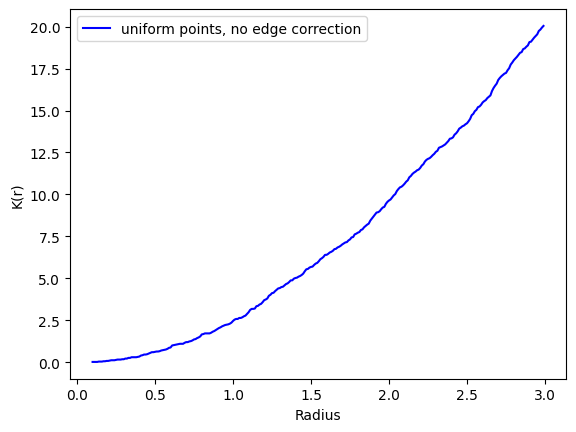

In [39]:
plot_ripleys_k(ks, radii, type="uniform", show=False)

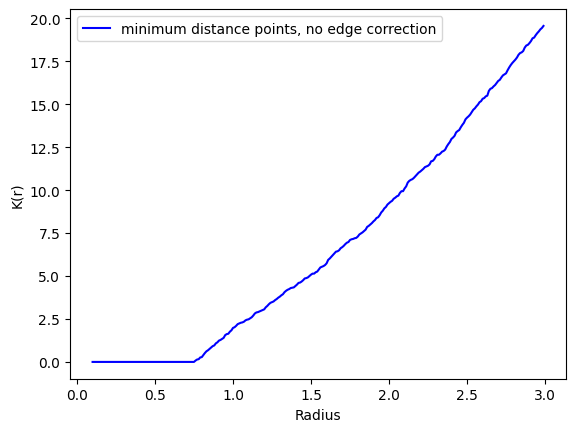

In [40]:
plot_ripleys_k(ks_r, radii, type="minimum distance")

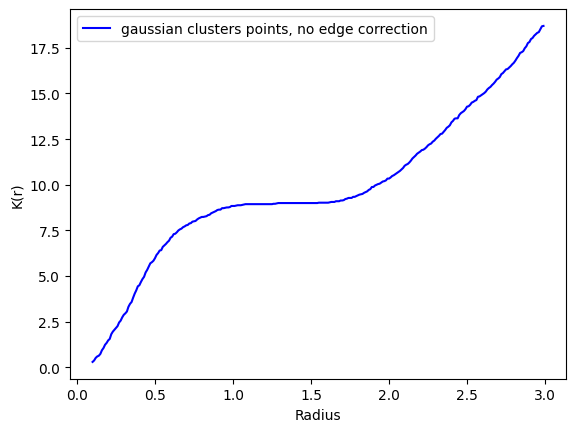

In [41]:
plot_ripleys_k(ks_g, radii, type="gaussian clusters")

## Ripley's K with edge correction

In [56]:
def plot_ripleys_k_ec(k, k_corrected, radii, type="uniform"):
    plt.plot(
        radii,
        k,
        color="k",
        label=f"{type} points, no edge correction",
        linestyle="-",
        alpha=0.5,
    )
    plt.plot(
        radii,
        k_corrected,
        color="k",
        label=f"{type} points, edge correction",
        linestyle="--",
    )
    plt.title("Ripley's K function")
    plt.legend()
    plt.xlabel("Radius")
    plt.ylabel("K(r)")
    plt.show()

In [57]:
# Uniform points
ks_corrected = ripleys_k_function(points, radii=radii, area=100, edge_correction=True)
ks_g_corrected = ripleys_k_function(
    points_g, radii=radii, area=100, edge_correction=True
)
ks_r_corrected = ripleys_k_function(
    points_r, radii=radii, area=100, edge_correction=True
)

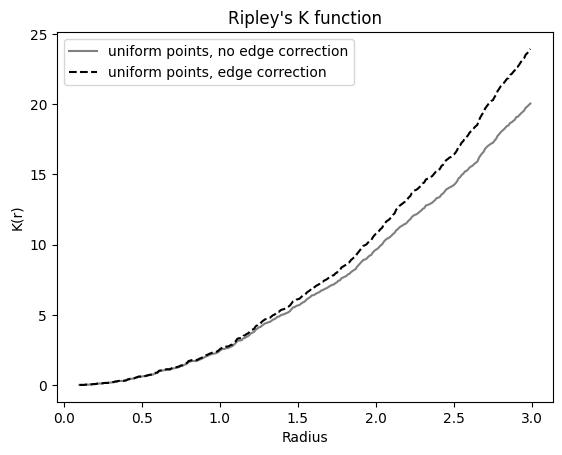

In [58]:
plot_ripleys_k_ec(ks, ks_corrected, radii, type="uniform")

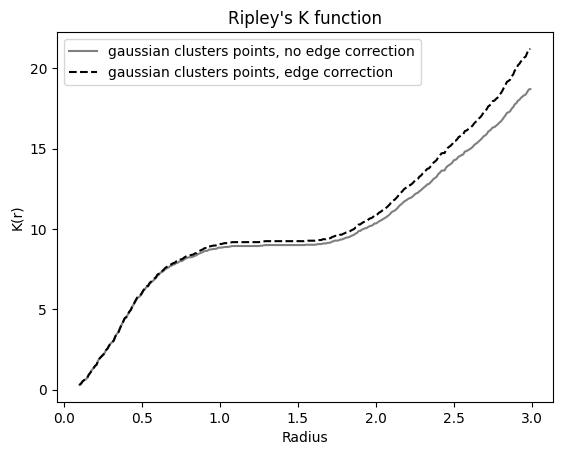

In [60]:
plot_ripleys_k_ec(ks_g, ks_g_corrected, radii, type="gaussian clusters")

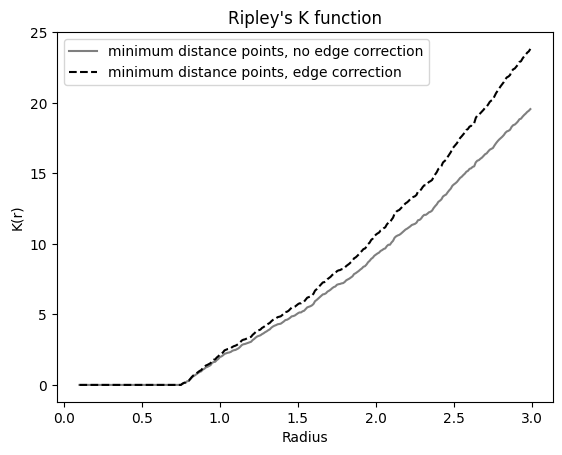

In [61]:
plot_ripleys_k_ec(ks_r, ks_r_corrected, radii, type="minimum distance")

# Null-hypothesis testing

In [68]:
# def simulate_dots_unif(num_points, x_max=10, y_max=10, seed=42):
#     """
#     Simulate uniformly distributed 2D points within a rectangular area.

#     Parameters:
#     ----------
#     num_points : int
#         Number of points to simulate.
#     x_max : float, optional
#         Maximum x-coordinate (default is 10). Minimum is 0.
#     y_max : float, optional
#         Maximum y-coordinate (default is 10). Minimum is 0.
#     seed : int, optional
#         Random seed for reproducibility (default is 42).

#     Returns:
#     -------
#     np.ndarray
#         Array of shape (num_points, 2), where each row is an (x, y) coordinate.
#     """
#     rng = np.random.default_rng(seed)
#     x_coords = rng.uniform(0, x_max, num_points)
#     y_coords = rng.uniform(0, y_max, num_points)
#     points = np.stack((x_coords, y_coords), axis=1)

#     return points

In [70]:
def simulate_dots_unif_batch(ndraw, num_points=100, x_max=10, y_max=10, seed=42):
    """
    Simulate ndraw batches of uniformly distributed 2D points.

    Returns:
    --------
    np.ndarray of shape (ndraw, num_points, 2)
    """
    rng = np.random.default_rng(seed)

    x = rng.uniform(0, x_max, size=(ndraw, num_points, 1))
    y = rng.uniform(0, y_max, size=(ndraw, num_points, 1))

    return np.concatenate([x, y], axis=-1)

In [71]:
ndraw = 1000  # Sufficiently large for statistics.
num_points = len(points)  # Same number of points as our data
points_multiple = simulate_dots_unif_batch(
    ndraw, num_points=num_points, x_max=10, y_max=10
)

## Mean nearest neighbour

In [82]:
def plot_envelope(ks, ks_multiple, alpha=5, label="uniform"):
    ndraw = len(ks_multiple)
    ks_multiple_mean = np.mean(ks_multiple, axis=0)
    bound_low = alpha / 2
    bound_upper = 100 - bound_low
    percentiles_low = np.percentile(ks_multiple, bound_low, axis=0)
    percentiles_high = np.percentile(ks_multiple, bound_upper, axis=0)

    plt.plot(
        radii,
        ks_multiple_mean,
        color="grey",
        label=f"mean K(r) of {ndraw} realizations",
    )
    plt.fill_between(
        radii,
        percentiles_low,
        percentiles_high,
        color="grey",
        alpha=0.3,
        label=f"{bound_low}-{bound_upper}% quantile range",
    )
    plt.plot(radii, ks, label=label)
    plt.legend()
    plt.xlabel("Radius")
    plt.ylabel("K(r)")
    plt.show()

In [91]:
nn_multiple = np.zeros(ndraw, dtype=float)
for i in range(ndraw):
    mean_i = np.mean(meanNN(points_multiple[i]))
    nn_multiple[i] = mean_i

In [96]:
alpha = 5
bound_low = alpha / 2
bound_upper = 100 - bound_low
percentile_low = np.percentile(nn_multiple, bound_low)
percentile_high = np.percentile(nn_multiple, bound_upper)

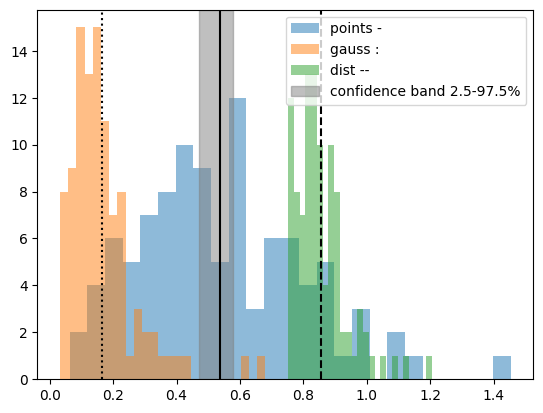

In [104]:
plt.hist(nndist_points, label="points -", alpha=0.5, bins=25)
plt.hist(nndist_gauss, label="gauss :", alpha=0.5, bins=25)
plt.hist(nndist_dist, label="dist --", alpha=0.5, bins=25)
plt.axvline(np.mean(nndist_points), c="k", linestyle="-")
plt.axvline(np.mean(nndist_gauss), c="k", linestyle=":")
plt.axvline(np.mean(nndist_dist), c="k", linestyle="--")
plt.axvspan(
    percentile_low,
    percentile_high,
    color="gray",
    alpha=0.5,
    label=f"confidence band {bound_low}-{bound_upper}%",
)
plt.legend()

## Nearest neighbor function

In [ ]:
nearest_neighbour_function(points, radii)

## Ripley's K

In [72]:
ks_multiple = np.zeros([ndraw, len(radii)], dtype=float)
for i in range(ndraw):
    ks_multiple[i] = ripleys_k_function(
        points_multiple[i], radii=radii, area=100, edge_correction=False
    )

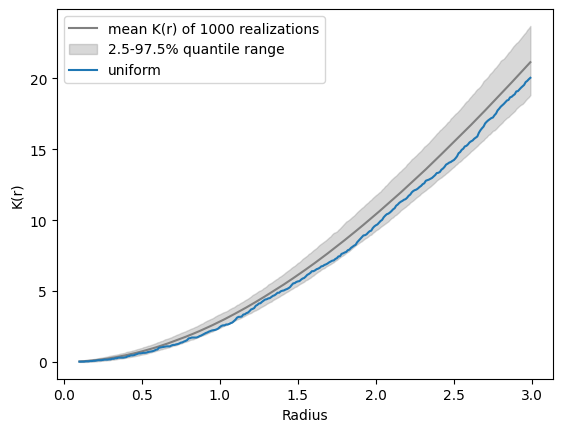

In [83]:
plot_envelope(ks, ks_multiple)

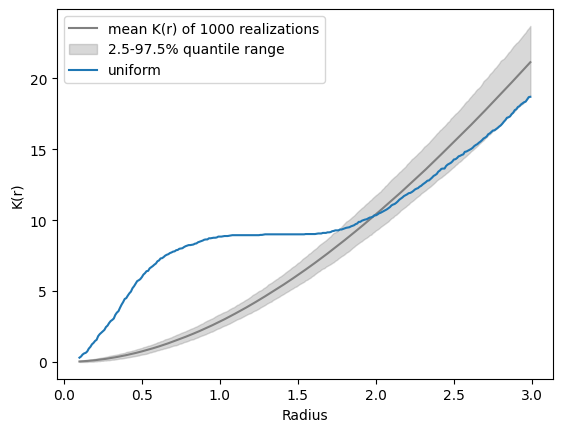

In [84]:
plot_envelope(ks_g, ks_multiple)

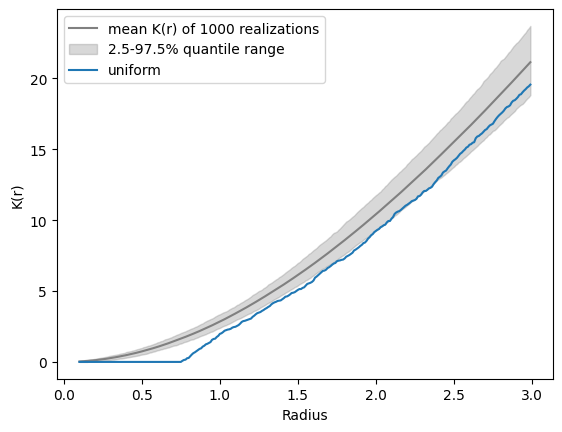

In [85]:
plot_envelope(ks_r, ks_multiple)

In [ ]:
plot_envelope(S_r, ks_multiple)